In [1]:
import numpy as np
import pandas as pd
import random
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# Seed 설정
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

#특성과 타겟 변수 분리
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [4]:
#기업가치 구간화
def parse_value(x):
    if pd.isnull(x): return 0
    elif '6000' in str(x): return 6
    elif '4500' in str(x): return 5
    elif '3500' in str(x): return 4
    elif '2500' in str(x): return 3
    elif '1500' in str(x): return 2
    else: return 1

#라벨 NaN값 처리
def fit_label_encoder(train_series, test_series):
    train_series = train_series.fillna('Missing').astype(str)
    test_series = test_series.fillna('Missing').astype(str)

    le = LabelEncoder()
    full_data = pd.concat([train_series, test_series])
    le.fit(full_data)

    return le, le.transform(train_series), le.transform(test_series)

           ID  설립연도     국가    분야      투자단계    직원 수 인수여부 상장여부  고객수(백만명)  \
0  TRAIN_0000  2009  CT005  이커머스  Series A  4126.0   No   No      56.0   
1  TRAIN_0001  2023  CT006   핀테크      Seed  4167.0  Yes   No      80.0   
2  TRAIN_0002  2018  CT007    기술  Series A  3132.0  Yes  Yes      54.0   
3  TRAIN_0003  2016  CT006   NaN      Seed  3245.0  Yes  Yes       NaN   
4  TRAIN_0004  2020  CT002  에듀테크      Seed  1969.0   No  Yes      94.0   

   총 투자금(억원)  연매출(억원)  SNS 팔로워 수(백만명)  기업가치(백억원)  성공확률  
0     3365.0   4764.0            4.71        NaN   0.3  
1     4069.0    279.0            1.00  2500-3500   0.8  
2     6453.0  12141.0            4.00  3500-4500   0.5  
3      665.0  10547.0            2.97        NaN   0.7  
4      829.0   9810.0            1.00  1500-2500   0.1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID         

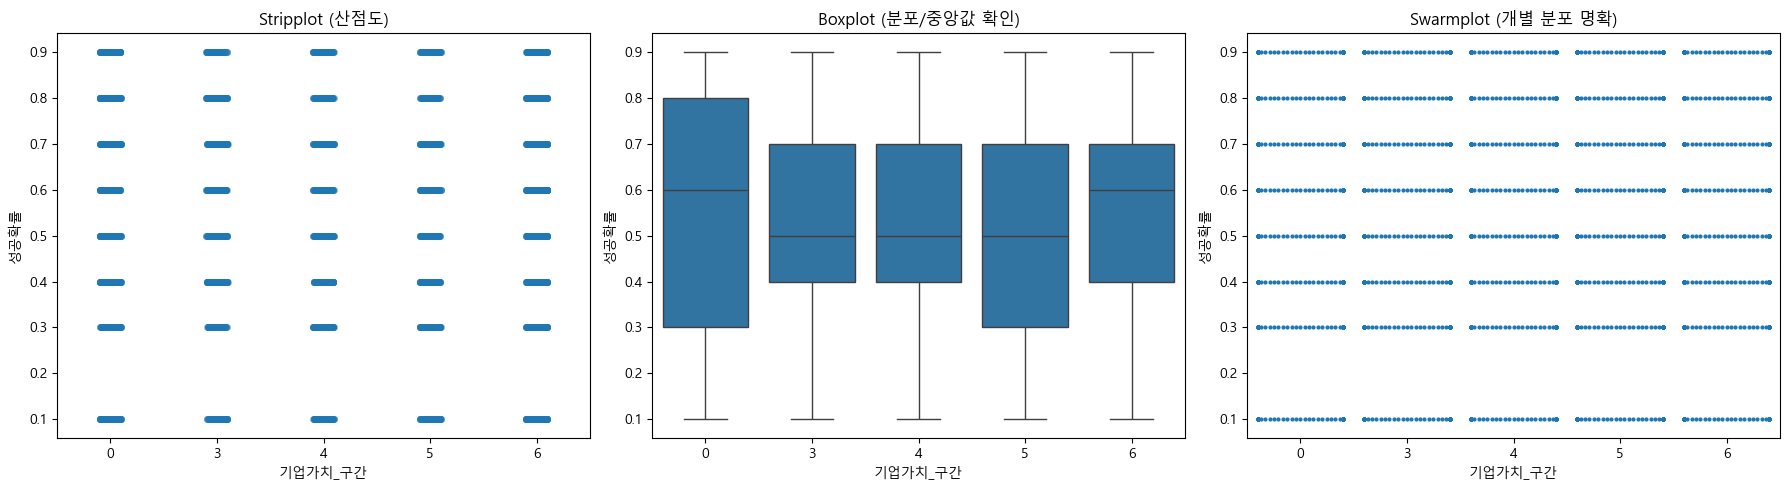

In [11]:
#산점도
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'AppleGothic' (Mac), 'NanumGothic' (Linux 설치 시)

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('train.csv')
print(df.head())
print(df.info())

df['기업가치_구간'] = df['기업가치(백억원)'].apply(parse_value)

plt.figure(figsize=(18, 5))

# Stripplot (기존)
plt.subplot(1, 3, 1)
sns.stripplot(data=df, x='기업가치_구간', y='성공확률', jitter=True, alpha=0.5)
plt.title('Stripplot (산점도)')

# Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='기업가치_구간', y='성공확률')
plt.title('Boxplot (분포/중앙값 확인)')

# Swarmplot
plt.subplot(1, 3, 3)
sns.swarmplot(data=df, x='기업가치_구간', y='성공확률', size=3)
plt.title('Swarmplot (개별 분포 명확)')

plt.tight_layout()
plt.show()

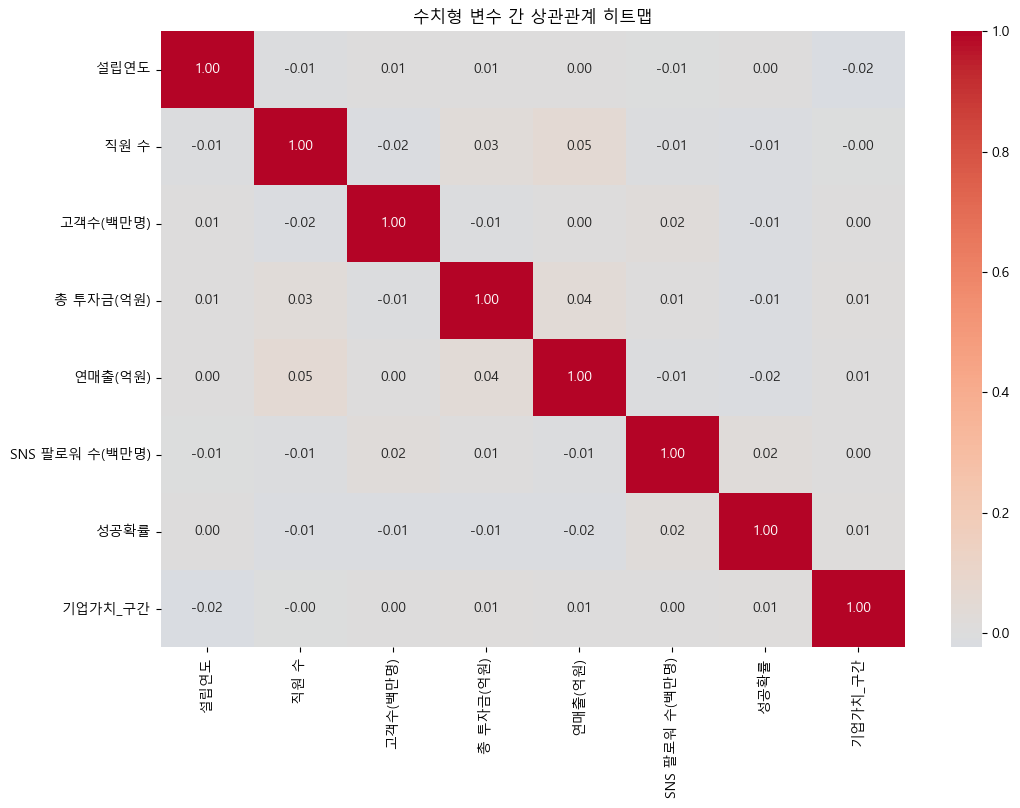

In [12]:
#숫자형 성공확률 포함 상관계수 heatmap
# 숫자형 데이터만 추출
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# 상관계수 계산
corr = numeric_cols.corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('수치형 변수 간 상관관계 히트맵')
plt.show()

전처리없는 수치형컬럼들과 성공확률과의 선형적 연관성은 없다

In [15]:
df[df['분야'].isna() & df['성공확률'].notna()]

,ID,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률,기업가치_구간
3,TRAIN_0003,2016,CT006,NaN,Seed,3245.0,Yes,Yes,NaN,665.0,10547.0,2.97,NaN,0.7,0
6,TRAIN_0006,2008,CT010,NaN,Series B,818.0,No,Yes,NaN,3049.0,666.0,0.76,2500-3500,0.4,4
8,TRAIN_0008,2005,CT002,NaN,Series B,NaN,No,No,NaN,2722.0,2568.0,4.94,NaN,0.9,0
9,TRAIN_0009,2009,CT008,NaN,Series B,1757.0,No,No,NaN,285.0,11758.0,2.33,NaN,0.5,0
22,TRAIN_0022,2004,CT007,NaN,Series A,4957.0,Yes,Yes,NaN,96.0,7304.0,4.08,NaN,0.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361,TRAIN_4361,2014,CT001,NaN,Series A,4971.0,Yes,No,NaN,2820.0,10761.0,3.84,2500-3500,0.1,4
4364,TRAIN_4364,2002,CT002,NaN,Series B,1980.0,Yes,Yes,NaN,4875.0,8403.0,4.12,4500-6000,0.1,6
4366,TRAIN_4366,2005,CT005,NaN,Series A,NaN,No,Yes,NaN,1502.0,2819.0,3.81,NaN,0.3,0
4370,TRAIN_4370,2005,CT006,NaN,Series A,237.0,No,No,NaN,6252.0,759.0,4.31,NaN,0.9,0


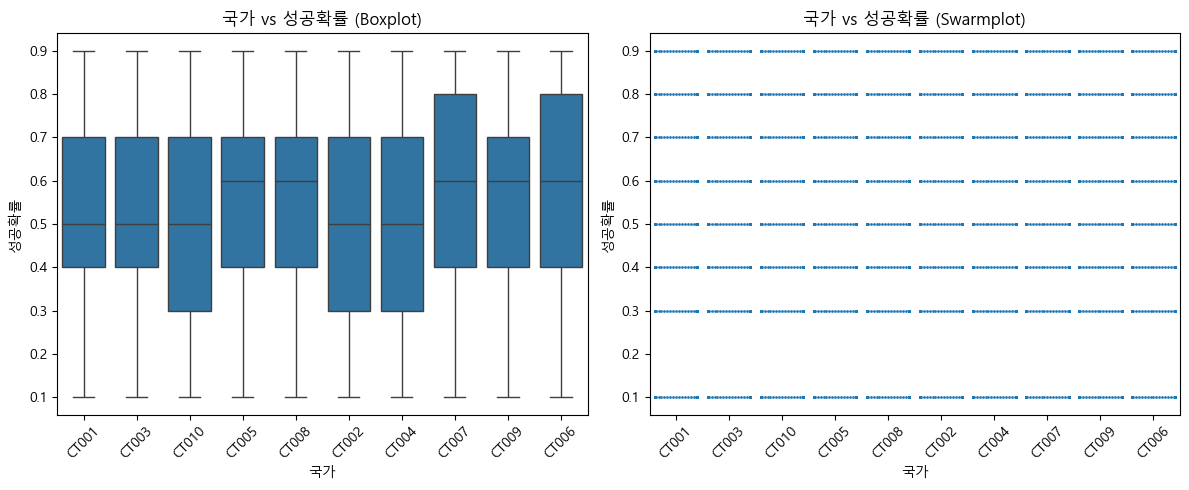

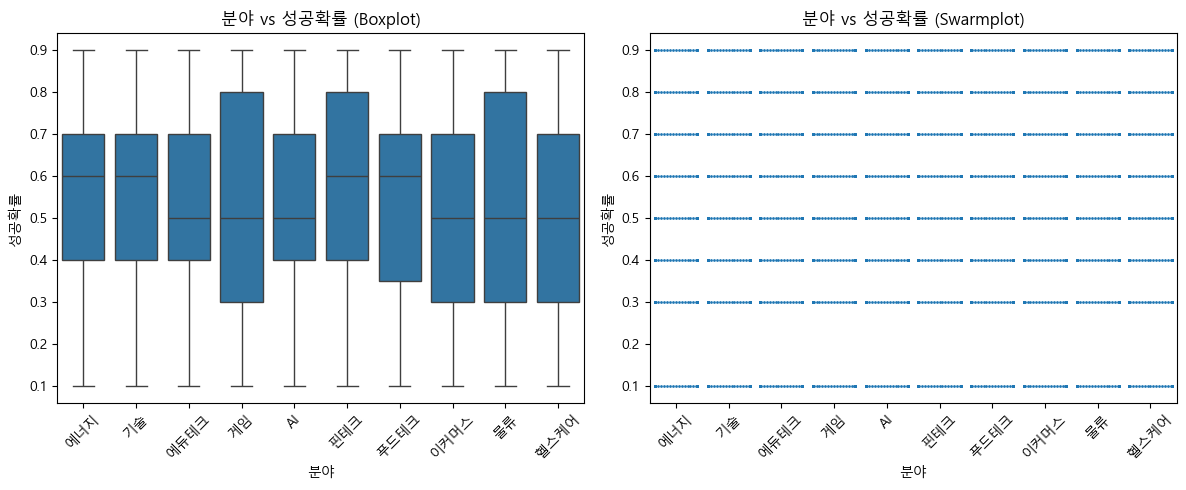

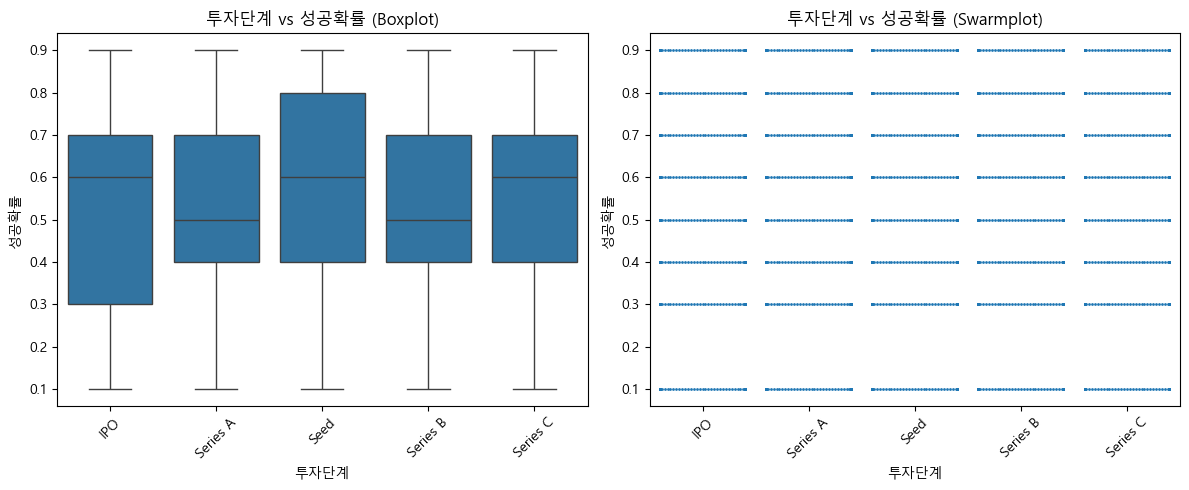

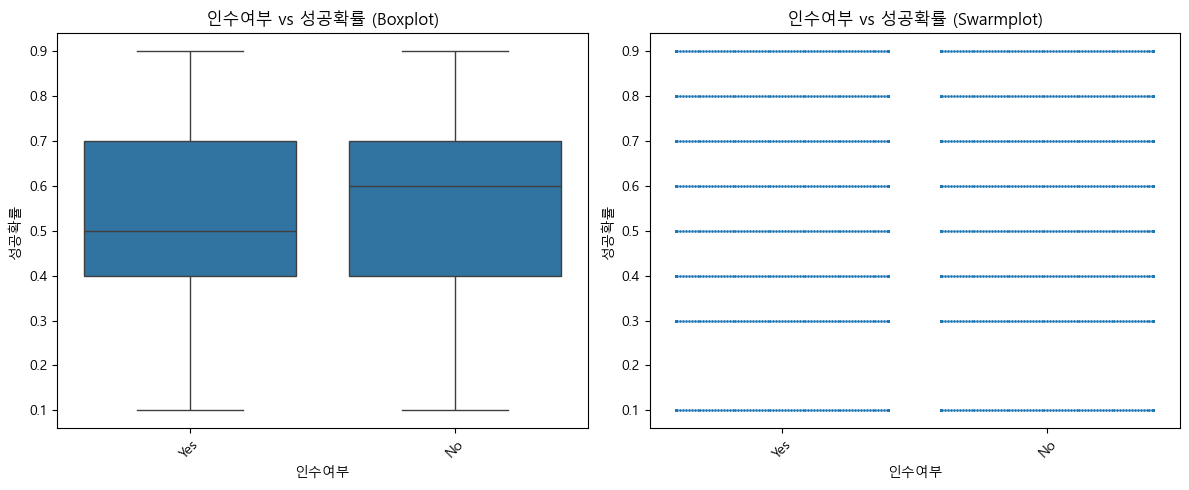

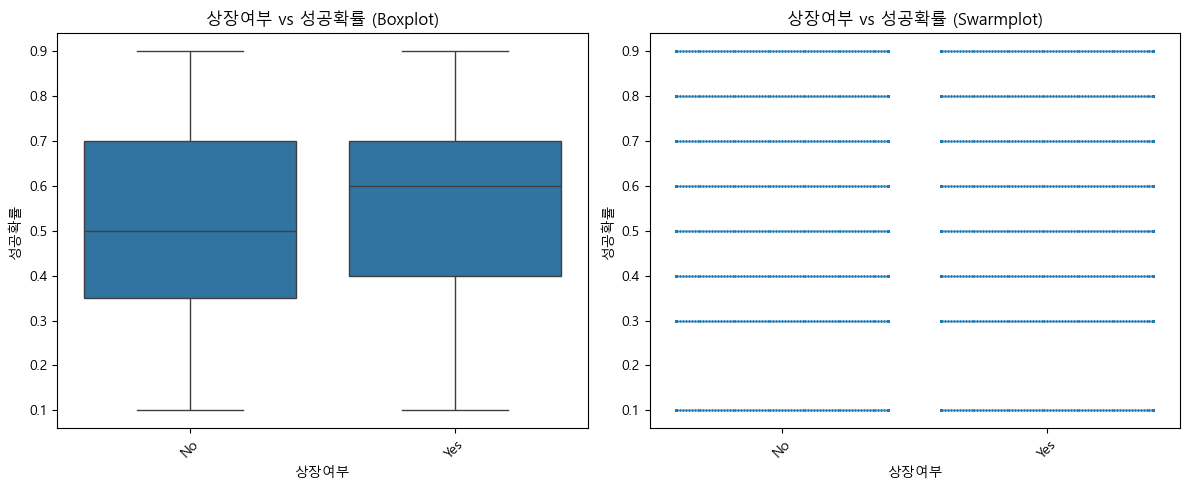

In [14]:
#범주형 범주랑 성공확률 시각화

# 분석할 범주형 변수 리스트
categorical_vars = ['국가', '분야', '투자단계', '인수여부', '상장여부']


# 시각화 반복
for col in categorical_vars:
    plt.figure(figsize=(12, 5))
    
    # Boxplot (중앙값, 사분위수 확인)
    plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=col, y='성공확률', order=train[col].value_counts().index)
    plt.title(f'{col} vs 성공확률 (Boxplot)')
    plt.xticks(rotation=45)
    
    # Swarmplot (개별 포인트 분포 시각화)
    plt.subplot(1, 2, 2)
    sns.swarmplot(data=train, x=col, y='성공확률', order=train[col].value_counts().index, size=2)
    plt.title(f'{col} vs 성공확률 (Swarmplot)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

결측치 전처리

In [16]:
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print(missing_ratio)

고객수(백만명)          0.301645
기업가치(백억원)         0.278793
분야                0.195841
직원 수              0.039762
설립연도              0.000000
국가                0.000000
ID                0.000000
인수여부              0.000000
투자단계              0.000000
총 투자금(억원)         0.000000
상장여부              0.000000
연매출(억원)           0.000000
SNS 팔로워 수(백만명)    0.000000
성공확률              0.000000
기업가치_구간           0.000000
dtype: float64


1. ML기반 결측치 예측 (Supervised Imputation)
2. Multivariate Imputation (MICE 방식)
3. 결측 자체를 Feature 활용

고객수	LightGBM 예측 + 결측 플래그 추가
기업가치	IterativeImputer + 결측 플래그 추가
분야 (범주형)	‘Unknown’ 대체 + 원핫인코딩 or Embedding
직원 수	LightGBM 예측 또는 중간값

라벨 인코딩

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np



In [48]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# ------------------------
# LightGBM 예측 기반 보간 함수
# ------------------------
def lgbm_impute(df, col):
    df = df.copy()
    df[col + '_결측여부'] = df[col].isnull().astype(int)

    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    num_cols = [c for c in num_cols if c != col and df[c].isnull().mean() < 0.4]

    train_data = df[df[col].notnull()]
    test_data = df[df[col].isnull()]

    if len(train_data) == 0 or train_data[num_cols].dropna().shape[0] == 0:
        print(f"[{col}] 학습에 사용할 수 있는 데이터가 부족합니다.")
        return df

    X_train = train_data[num_cols].fillna(train_data[num_cols].mean())
    y_train = train_data[col]
    X_test = test_data[num_cols].fillna(train_data[num_cols].mean())

    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    df.loc[df[col].isnull(), col] = model.predict(X_test)

    return df

# ------------------------
# 기업가치 문자열 → 구간 정수 매핑 함수
# ------------------------
def parse_value(x):
    if pd.isnull(x): return 0
    elif '6000' in str(x): return 6
    elif '4500' in str(x): return 5
    elif '3500' in str(x): return 4
    elif '2500' in str(x): return 3
    elif '1500' in str(x): return 2
    else: return 1

# ------------------------
# 전체 전처리 흐름
# ------------------------

# 0. 데이터 결합
train['is_train'] = 1
test['is_train'] = 0
df_all = pd.concat([train, test], axis=0).reset_index(drop=True)

# 1. 분야 결측치 대체
df_all['분야'] = df_all['분야'].fillna('Unknown')

# 2. 기업가치(백억원): 문자열 구간을 정수로 변환 + 0 → 결측 + IterativeImputer
df_all['기업가치(백억원)'] = df_all['기업가치(백억원)'].apply(parse_value).astype(float)
df_all['기업가치(백억원)_결측여부'] = (df_all['기업가치(백억원)'] == 0).astype(int)
df_all.loc[df_all['기업가치(백억원)'] == 0, '기업가치(백억원)'] = np.nan
df_all[['기업가치(백억원)']] = IterativeImputer(random_state=42).fit_transform(df_all[['기업가치(백억원)']])

# 3. 고객수(백만명): 숫자 변환 + LGBM 예측 보간 + 결측 플래그
df_all['고객수(백만명)'] = pd.to_numeric(df_all['고객수(백만명)'], errors='coerce')
df_all = lgbm_impute(df_all, '고객수(백만명)')

# 4. 직원 수: LGBM 예측 보간 or 중간값 (여기선 LGBM 사용)
if df_all['직원 수'].isnull().sum() > 0:
    df_all = lgbm_impute(df_all, '직원 수')

# 5. 범주형 라벨 인코딩 (또는 원핫 인코딩)
cat_cols = df_all.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    df_all[col] = df_all[col].astype(str)
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col])

# 6. train/test 복원
train_processed = df_all[df_all['is_train'] == 1].drop(columns=['is_train']).copy()
test_processed = df_all[df_all['is_train'] == 0].drop(columns=['is_train']).copy()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 4264, number of used features: 9
[LightGBM] [Info] Start training from score 49.476079
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 5881, number of used features: 10
[LightGBM] [Info] Start training from score 2474.725217


학습모델
결측값 처리는 LightGBM 보간, IterativeImputer 등을 활용해 정교하게 수행하고,

범주형 변수는 라벨 인코딩,

모델 학습은 TabNet + LightGBM + GradientBoosting + XGBoost의 앙상블 구조로 진행하고 있어.

In [66]:
#파생변수
derived_features = [
    '투자대비매출',
    '직원당투자금',
    '고객당매출',
    '기업가치대비매출',
    '설립후투자',
    '가치대비단계',
    '설립기간매출',
    '설립기간고객',
    'SNS대비투자',
    'SNS팔로워구간'
]
base_features = [
    '설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부',
    '고객수(백만명)', '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)'
]

# features = 기본_features + engineered_features
# drop_cols = ['성공확률', '설립연도']  # 타겟과 불필요한 원천 변수
# features = [col for col in train.columns if col not in drop_cols]


for df in [train_processed, test_processed]:
    df['투자대비매출'] = df['연매출(억원)'] / (df['총 투자금(억원)'] + 1)
    df['직원당투자금'] = df['총 투자금(억원)'] / (df['직원 수'] + 1)
    df['고객당매출'] = df['연매출(억원)'] / (df['고객수(백만명)'] + 1)
    df['기업가치대비매출'] = df['연매출(억원)'] / (df['기업가치(백억원)'] + 1)
    df['설립후투자'] = df['총 투자금(억원)'] / ((2025 - df['설립연도']) + 1)
    df['가치대비단계'] = df['기업가치(백억원)'] / (df['투자단계'] + 1)
    df['설립기간매출'] = df['연매출(억원)'] / ((2025 - df['설립연도']) + 1)
    df['설립기간고객'] = df['고객수(백만명)'] / ((2025 - df['설립연도']) + 1)
    df['SNS대비투자'] = df['SNS 팔로워 수(백만명)'] / (df['총 투자금(억원)'] + 1)

# SNS 구간화
def sns_bin(x):
    if pd.isna(x): return 0
    if x < 1: return 0
    elif x < 3: return 1
    elif x < 5: return 2
    else: return 3
train_processed['SNS팔로워구간'] = train_processed['SNS 팔로워 수(백만명)'].apply(sns_bin)
test_processed['SNS팔로워구간'] = test_processed['SNS 팔로워 수(백만명)'].apply(sns_bin)

features = base_features + derived_features
print(features)
X = train_processed[features].copy()
X_test = test_processed[features].copy()
y = train['성공확률']


['설립연도', '국가', '분야', '투자단계', '직원 수', '인수여부', '상장여부', '고객수(백만명)', '총 투자금(억원)', '연매출(억원)', 'SNS 팔로워 수(백만명)', '기업가치(백억원)', '투자대비매출', '직원당투자금', '고객당매출', '기업가치대비매출', '설립후투자', '가치대비단계', '설립기간매출', '설립기간고객', 'SNS대비투자', 'SNS팔로워구간']


XGBRegressor(
    n_estimators=2000,        # 충분히 크게 설정 (early stopping으로 제어)
    learning_rate=0.01~0.05,  # 작게 설정 (대신 n_estimators 크게)
    max_depth=5~10,           # 너무 깊으면 오히려 과적합
    min_child_weight=1~10,    # leaf의 최소한의 가중치 합
    gamma=0~10,               # node split 최소 loss 감소
    subsample=0.7~1.0,
    colsample_bytree=0.7~1.0,
    reg_alpha=0~1,            # L1
    reg_lambda=0~5,           # L2
    ...
)
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=7,
    min_child_weight=5,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=3,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="mae"
)

In [80]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 42,
        "n_jobs": -1
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_maes = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        preds = model.predict(X_valid)
        val_maes.append(mean_absolute_error(y_valid, preds))

    return np.mean(val_maes)

# 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best Trial:")
print(study.best_trial.params)


[I 2025-04-30 16:04:48,476] A new study created in memory with name: no-name-2497caf7-fed7-495f-8e42-f0a9d4d0b4ea
[I 2025-04-30 16:05:05,294] Trial 0 finished with value: 0.2081361126737881 and parameters: {'n_estimators': 1644, 'learning_rate': 0.13881893066796533, 'max_depth': 10, 'subsample': 0.9126599823194317, 'colsample_bytree': 0.5401934879393522, 'reg_alpha': 1.7709151868019575, 'reg_lambda': 3.4248806308292674}. Best is trial 0 with value: 0.2081361126737881.
[I 2025-04-30 16:05:27,673] Trial 1 finished with value: 0.2041400222329322 and parameters: {'n_estimators': 1204, 'learning_rate': 0.011583009792484713, 'max_depth': 11, 'subsample': 0.5852223501451422, 'colsample_bytree': 0.9428557078059847, 'reg_alpha': 4.7099838161701735, 'reg_lambda': 2.9621239321590047}. Best is trial 1 with value: 0.2041400222329322.
[I 2025-04-30 16:06:00,430] Trial 2 finished with value: 0.20415020331301723 and parameters: {'n_estimators': 1526, 'learning_rate': 0.007726550776076377, 'max_depth':

KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import LabelEncoder




# object 컬럼 처리
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        # train과 test 합쳐서 fit
        full_data = pd.concat([X[col], X_test[col]], axis=0).astype(str)
        le.fit(full_data)
        X[col] = le.transform(X[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

# 기업가치가 object라면 숫자로 변환
for df in [X, X_test]:
    if '기업가치(백억원)' in df.columns and df['기업가치(백억원)'].dtype == 'object':
        df['기업가치(백억원)'] = df['기업가치(백억원)'].replace(',', '', regex=True).astype(float)

# KFold 학습 재시작
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
models = []
test_preds = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")
    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

    model = XGBRegressor(
        n_estimators=1325,
        learning_rate=0.00375,
        max_depth=15,
        subsample=0.58315,
        colsample_bytree=0.75715,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=15,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    cv_scores.append(mae)
    models.append(model)
    test_preds.append(model.predict(X_test))
    print(f"Fold {fold+1} MAE: {mae:.4f}")

print(f"\nAverage MAE across folds: {np.mean(cv_scores):.5f}")
final_test_pred = np.clip(np.mean(test_preds, axis=0), 0, 1)




Fold 1
Fold 1 MAE: 0.2033
Fold 2
Fold 2 MAE: 0.2046
Fold 3


KeyboardInterrupt: 

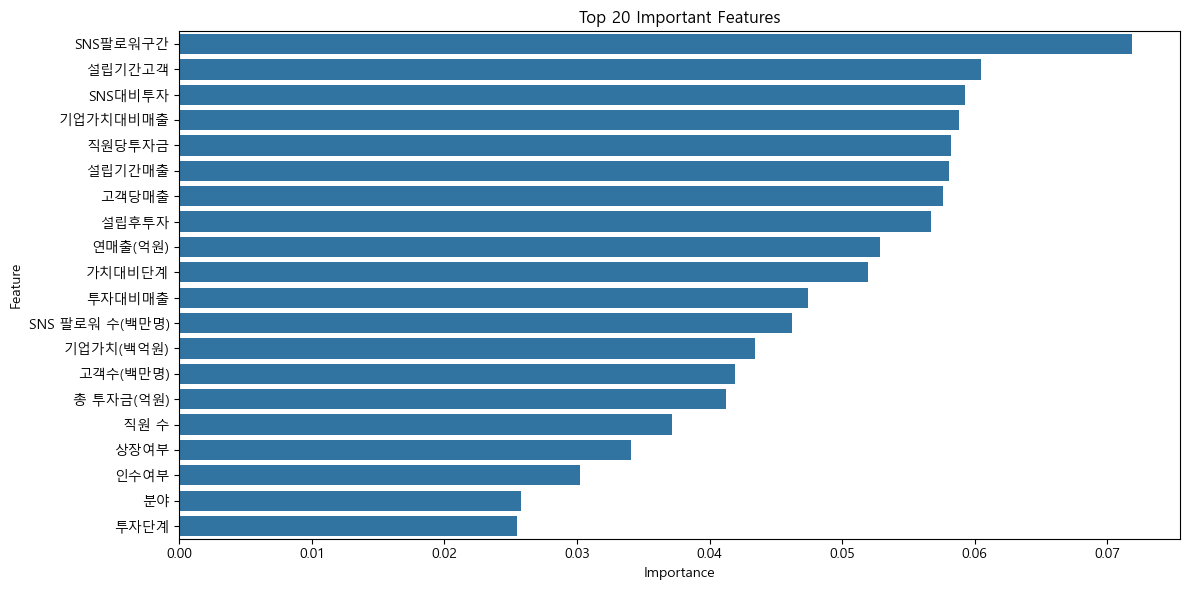

In [65]:
# 평균 feature importance 계산
feature_importances = np.mean(
    [model.feature_importances_ for model in models],
    axis=0
)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 상위 중요 변수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()